<a href="https://colab.research.google.com/github/xedinseu/text_cleaning/blob/main/text_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Отдельно хочу отметить, что до начала обучения (но после пилотной пробы сети) я предподготовил изображения - высота у многих изображений не соответствовала максимальной, и сверху и снизу таких изображений был добавлен белый фон чтобы добить высоту до 420 пикселей

In [1]:
# инфа по карте коллаба
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install -q gputil
!pip install -q psutil
!pip install -q humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
process = psutil.Process(os.getpid())
print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
print("GPU Model: ", gpu.name)


Gen RAM Free: 12.8 GB  | Proc size: 118.5 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB
GPU Model:  Tesla P100-PCIE-16GB


In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, concatenate, Dense, Dropout, BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, Flatten,Reshape
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.preprocessing import image
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import os
import time
import random

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
images_dir = '/content/drive/MyDrive/Базы/text_cleaning/' # зададим имя папки в которой находятся данные
img_height = 424 # зададим высоту изображений
img_width = 544 # зададим ширину избражений

In [5]:
def plotImages(xTrain, pred, shape=(img_height, img_width)): # создадим функцию для вывода изображений как картинок
  n = 7  # количество картинок, которые хотим показать
  plt.figure(figsize=(28, 7)) # указываем размеры фигуры
  for i in range(n): # для каждой картинки из n(7)
      index = i
      # Показываем картинки из тестового набора
      ax = plt.subplot(2, n, i + 1) # выведем область рисования Axes
      plt.imshow(xTrain[index].reshape(shape)) # отрисуем правильные картинки в размере 112*80      
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

      # Показываем восстановленные картинки
      ax = plt.subplot(2, n, i + 1 + n) # выведем область рисования Axes 
      plt.imshow(pred[index].reshape(shape)) # отрисуем обработанные сеткой картинки в размере 112*80     
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
  plt.show()

In [6]:
# функция загрузки изображений, на вход принемает имя папки с изображениями, высоту и ширину к которой будут преобразованы загружаемые изображения
def load_images(images_dir, img_height, img_width): 
  list_images = [] # создаем пустой список в который будем загружать изображения
  for img in os.listdir(images_dir): # получим список изображений и для каждого изображения
  # добавим в список изображение в виде массива, с заданными размерами, в отенках серого
    list_images.append(image.img_to_array(image.load_img(os.path.join(images_dir, img), target_size=(img_height, img_width), color_mode='grayscale')))
  return np.array(list_images) # возвращаем numpy массив загруженных избражений

In [7]:
cur_time = time.time() 
xTrain = load_images(images_dir+'train_X', img_height, img_width) # загрузим избражения лиц
xTrain = xTrain/255 # отнормируем изображения от 0 до 1
yTrain = load_images(images_dir+'train_Y', img_height, img_width) # загрузим избражения лиц
yTrain = yTrain/255 # отнормируем изображения от 0 до 1
xTest = load_images(images_dir+'test', img_height, img_width) # загрузим избражения лиц
xTest = xTest/255 # отнормируем изображения от 0 до 1

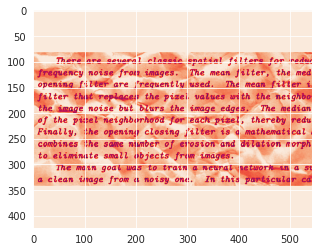

In [8]:
plt.imshow(xTrain[10][:,:,0])

In [9]:
xTrain.shape

(144, 424, 544, 1)

In [10]:
xTrain,xVal,yTrain,yVal = train_test_split(xTrain, yTrain, test_size=0.1)

In [11]:
def denoiseAutoencoder(): # объявляем функцию создания автокодировщика для подавления шума
    img_input = Input((img_height, img_width,1)) # задаём входные размеры

    x1 = Conv2D(256, (4, 4), strides=2, activation='relu', padding='same')(img_input)
    x1 = Conv2D(128, (4, 4), strides=2, activation='relu', padding='same')(x1)

    x1 = Conv2D(256, (4, 4), activation='relu', padding='same')(x1)

    x1 = Conv2DTranspose(128, (4, 4), strides=2, padding='same')(x1)
    x1 = Conv2DTranspose(256, (4, 4), strides=2, padding='same')(x1)

    x2 = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(img_input)
    x2 = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x2)

    x2 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)

    x2 = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x2)
    x2 = Conv2DTranspose(256, (3, 3), strides=2, padding='same')(x2) 

    x = concatenate([x1,x2])
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) # и пропускаем через финальный слой двумерной свертки

    model = Model(img_input, x) # собрали модель с зашумленной картинкой на вход и с очищенной от шума на выход
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='mse') # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки

    return model # функция вернет модель подавления шума

In [12]:
filename=images_dir + 'log_v3.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=False)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75,patience=15, min_lr=0.000001)
modelDenoise = denoiseAutoencoder()
# Подаем на вход зашумленные картинки, а на выход правильные, исходные картинки, и обучаем
modelDenoise.fit(xTrain, yTrain, epochs=200, batch_size=4, validation_data = (xVal, yVal), callbacks=[reduce_lr,history_logger])

Epoch 1/200
33/33 [==============================] - 40s 578ms/step - loss: 0.1075 - val_loss: 0.0699
Epoch 2/200
33/33 [==============================] - 16s 477ms/step - loss: 0.0733 - val_loss: 0.0699
Epoch 3/200
33/33 [==============================] - 16s 478ms/step - loss: 0.0733 - val_loss: 0.0699
Epoch 4/200
33/33 [==============================] - 16s 478ms/step - loss: 0.0733 - val_loss: 0.0699
Epoch 5/200
33/33 [==============================] - 16s 478ms/step - loss: 0.0732 - val_loss: 0.0699
Epoch 6/200
33/33 [==============================] - 16s 478ms/step - loss: 0.0732 - val_loss: 0.0699
Epoch 7/200
33/33 [==============================] - 16s 480ms/step - loss: 0.0732 - val_loss: 0.0697
Epoch 8/200
33/33 [==============================] - 16s 478ms/step - loss: 0.0667 - val_loss: 0.0587
Epoch 9/200
33/33 [==============================] - 16s 479ms/step - loss: 0.0580 - val_loss: 0.0553
Epoch 10/200
33/33 [==============================] - 16s 479ms/step - loss: 0.053

In [13]:
modelDenoise.save(images_dir + 'modelDenoise_v3.h5')

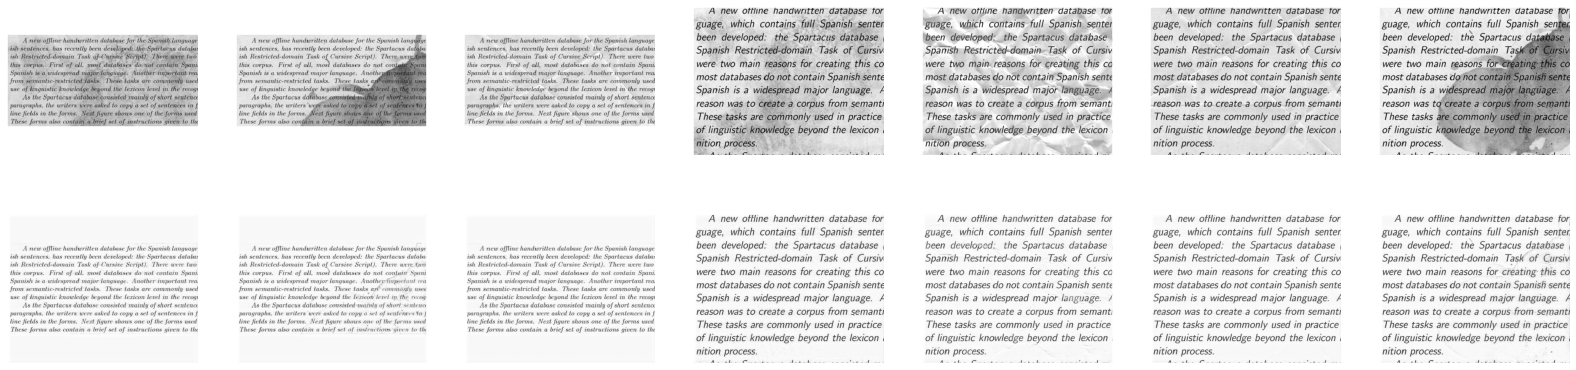

In [14]:
yTest = modelDenoise.predict(xTest)
plotImages(xTest, yTest) # взглянем как отрабатывает шумоподавление на зашумленных картинках